In [1]:
# Connecting to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Installing the required libraries
!pip install sentencepiece optuna
!pip install torch huggingface_hub
!pip install transformers datasets 
!pip install rouge.score nltk py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.1 MB/s 
     |████████████████████████████████| 348 kB 66.3 MB/s 
     |████████████████████████████████| 81 kB 11.6 MB/s 
     |████████████████████████████████| 210 kB 75.7 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 147 kB 79.4 MB/s 
     |████████████████████████████████| 112 kB 71.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=343528cf206823152f30557a4495b5c12c369aa5a125d742f6d599d3e7b6cd35
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      

In [3]:
# Importing the necessary libraries
import torch
import numpy as np
import pandas as pd
import datasets
import nltk
import optuna
import transformers

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# Importing the necessary libraries
import torch
import numpy as np
import pandas as pd
import datasets
import nltk
import optuna
import transformers

nltk.download('punkt')

# Create function for printing 
def print_custom(text):
    print('\n')
    print(text)
    print('-'*100)

# Specify our parameter and project variables
# These parameter range can be changed with respect to amount of processing power available (GPU)
LR_MIN = 4e-5
LR_CEIL = 0.01
WD_MIN = 4e-5
WD_CEIL = 0.01
MIN_EPOCHS = 8
MAX_EPOCHS = 15
MIN_BATCH_SIZE = 4
MAX_BATCH_SIZE = 6
NUM_TRIALS = 1
WARMUP_RATIO_MIN = 0.0
WARMUP_RATIO_MAX = 0.1
SAVE_DIR = 'opt-test'
MODEL_NAME = 'google/pegasus-x-base'
MAX_INPUT = 512
MAX_TARGET = 128

# Selecting the first 1000 rows just to see if the GPU issue doesnt recreate as the dataset is large
dataset_path = 'gdrive/My Drive/fyp/xsum/'
data = pd.read_csv(dataset_path + 'xsum.csv', encoding='latin-1')
data = data[0:1000]

metric = datasets.load_metric('rouge')
data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,document,summary
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...
1,A fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...
2,Ferrari appeared in a position to challenge un...,Lewis Hamilton stormed to pole position at the...
3,"John Edward Bates, formerly of Spalding, Linco...",A former Lincolnshire Police officer carried o...
4,Patients and staff were evacuated from Cerahpa...,An armed man who locked himself into a room at...
...,...,...
995,"If confirmed, the ""exomoon"" is likely to be ab...",A team of astronomers has potentially discover...
996,"Jacob Murphy fired in a 25-yard shot, his firs...",Norwich City made a great start to life back i...
997,"Speaking to reporters at the G20 summit, the u...",David Cameron has made an impassioned defence ...
998,"The Swans are up to 12th in the table, 13 poin...",Swansea City head coach Francesco Guidolin bel...


In [7]:
# Loading tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

In [8]:
# Preprocessing the data
prefix = "summarize: "
def preprocess_data(data_to_process):
    #get the document text
    if 't5' in MODEL_NAME: 
        inputs = [prefix + doc for doc in data_to_process["document"]]
    else:
        inputs = [document for document in data_to_process['document']]

    #tokenize text
    model_inputs = tokenizer(inputs,  max_length=MAX_INPUT, padding='max_length', truncation=True)

    #tokenize labels
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(data_to_process['summary'], max_length=MAX_TARGET, padding='max_length', truncation=True)
        
    model_inputs['labels'] = targets['input_ids']
    return model_inputs

#  Perform a train test split of 80:20 ratio on the dataset
train_dataset = data[:int(len(data)*0.7)]
test_dataset = data[int(len(data)*0.7):int(len(data)*0.85)]
validation_dataset = data[int(len(data)*0.85):]

# Creating the dataset dictionary
data = datasets.DatasetDict({ 'train': datasets.Dataset.from_pandas(train_dataset), 
                              'test': datasets.Dataset.from_pandas(test_dataset),
                              'validation': datasets.Dataset.from_pandas(train_dataset)})


In [9]:
# Preprocess the data
tokenize_data = data.map(preprocess_data, batched = True, remove_columns=['document', 'summary'])

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
#sample the data
train_sample = tokenize_data['train'].shuffle(seed=123).select(range(500))
validation_sample = tokenize_data['validation'].shuffle(seed=123).select(range(250))
test_sample = tokenize_data['test'].shuffle(seed=123).select(range(100))
     
# Update the tokenize_data dictionary
tokenize_data['train'] = train_sample
tokenize_data['validation'] = validation_sample
tokenize_data['test'] = test_sample

tokenize_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 250
    })
})

In [11]:
#load model
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# We are using batch_size to handle with the GPU limitation but if GPU size is not a limitation please use the recommend batch size from the hyperparameters
batch_size = 1

#data_collator to create batches. It preprocess data with the given tokenizer
data_collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)

Downloading:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

In [12]:
#####################
# metrics
# compute rouge for evaluation 
#####################

def compute_rouge(pred):
    predictions, labels = pred
    #decode the predictions
    decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    #decode labels
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    #compute results
    res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
    res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

    #compute the average of the rouge scores
    pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    res['gen_len'] = np.mean(pred_lens)

    return {k: round(v, 4) for k, v in res.items()}


In [13]:
# Performing hyperparameter training
print_custom('Performing hyperparameter training....')
def objective(trial: optuna.Trial):
    # Specify the training arguments and hyperparameter tune every arguments which are possible to tune
    training_args = transformers.Seq2SeqTrainingArguments(
        report_to="none",
        save_total_limit=1,
        output_dir=SAVE_DIR,
        run_name=MODEL_NAME,
        save_strategy="epoch",
        greater_is_better=True,
        predict_with_generate=True,
        load_best_model_at_end=True,
        evaluation_strategy="epoch",
        weight_decay=trial.suggest_float("weight_decay", WD_MIN, WD_CEIL, log=True),
        learning_rate=trial.suggest_float("learning_rate", LR_MIN, LR_CEIL, log=True),
        num_train_epochs=trial.suggest_int("num_train_epochs", MIN_EPOCHS, MAX_EPOCHS),
        warmup_ratio=trial.suggest_float("warmup_ratio", WARMUP_RATIO_MIN, WARMUP_RATIO_MAX),
        per_device_eval_batch_size=trial.suggest_int("per_device_eval_batch_size", MIN_BATCH_SIZE, MAX_BATCH_SIZE),
        per_device_train_batch_size=trial.suggest_int("per_device_train_batch_size", MIN_BATCH_SIZE, MAX_BATCH_SIZE),
    )

    # Create the trainer
    trainer = transformers.Seq2SeqTrainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=data_collator,
        eval_dataset=tokenize_data["test"],
        train_dataset=tokenize_data["train"],
    )

    # Train the model
    trainer.train()

    torch.cuda.empty_cache()

    # Evaluate the model
    metrics = trainer.evaluate()

    torch.cuda.empty_cache()

    # Return the loss
    return metrics["eval_loss"]

# Create the study
print_custom('Creating the study')
study = optuna.create_study(direction="minimize")

# Clearing the cuda memory
import torch
torch.cuda.empty_cache()

# Optimize the objective function
print_custom('Optimizing the objective function')
study.optimize(objective, n_trials=NUM_TRIALS)


[I 2022-12-21 09:18:53,476] A new study created in memory with name: no-name-915868d7-0713-4882-b859-24010bda934b




Performing hyperparameter training....
----------------------------------------------------------------------------------------------------


Creating the study
----------------------------------------------------------------------------------------------------


Optimizing the objective function
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 500
  Num Epochs = 12
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 1500
  Number of trainable parameters = 272292096
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,1.255424
2,No log,1.283745
3,No log,1.275890
4,1.231000,1.288146
5,1.231000,1.404430
6,1.231000,1.456458
7,1.231000,1.808488
8,0.461200,1.744368
9,0.461200,1.845556
10,0.461200,2.080306


***** Running Evaluation *****
  Num examples = 100
  Batch size = 6
Saving model checkpoint to opt-test/checkpoint-125
Configuration saved in opt-test/checkpoint-125/config.json
Model weights saved in opt-test/checkpoint-125/pytorch_model.bin
tokenizer config file saved in opt-test/checkpoint-125/tokenizer_config.json
Special tokens file saved in opt-test/checkpoint-125/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 100
  Batch size = 6
Saving model checkpoint to opt-test/checkpoint-250
Configuration saved in opt-test/checkpoint-250/config.json
Model weights saved in opt-test/checkpoint-250/pytorch_model.bin
tokenizer config file saved in opt-test/checkpoint-250/tokenizer_config.json
Special tokens file saved in opt-test/checkpoint-250/special_tokens_map.json
Deleting older checkpoint [opt-test/checkpoint-125] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 100
  Batch size = 6
Saving model checkpoint to opt-test/checkpoint-375
Con

[I 2022-12-21 09:49:57,092] Trial 0 finished with value: 2.585970163345337 and parameters: {'weight_decay': 0.0005710053308981711, 'learning_rate': 0.0057371350730593355, 'num_train_epochs': 12, 'warmup_ratio': 0.06738084958044255, 'per_device_eval_batch_size': 6, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 2.585970163345337.


In [14]:
# Print the best parameters
print_custom('Printing the best parameters')
print(study.best_params)

# Hyperparameter results
learning_rate = study.best_params['learning_rate']
weight_decay = study.best_params['weight_decay']
num_train_epochs = study.best_params['num_train_epochs']
warmup_ratio = study.best_params['warmup_ratio']
per_device_train_batch_size = study.best_params['per_device_train_batch_size']
per_device_eval_batch_size = study.best_params['per_device_eval_batch_size']

# Create the training arguments
args = transformers.Seq2SeqTrainingArguments(
    'generalization-summary',
    evaluation_strategy='epoch',
    learning_rate=learning_rate,
    per_device_train_batch_size=1, # this is due to GPU limitation else per_device_train_batch_size should be used 
    per_device_eval_batch_size= 1, # this is due to GPU limitation else per_device_eval_batch_size should be used
    gradient_accumulation_steps=2,
    weight_decay=weight_decay,
    save_total_limit=2,
    warmup_ratio=warmup_ratio,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    eval_accumulation_steps=1,
    fp16=True
  )
#only CUDA available -> fp16=True

# Create the trainer
trainer = transformers.Seq2SeqTrainer(
    model, 
    args,
    train_dataset=tokenize_data['train'],
    eval_dataset=tokenize_data['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)
     
# !nvidia-smi

# Clearing the cuda memory
import torch
torch.cuda.empty_cache()

# Train the model
trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 500
  Num Epochs = 12
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 2
  Total optimization steps = 3000
  Number of trainable parameters = 272292096




Printing the best parameters
----------------------------------------------------------------------------------------------------
{'weight_decay': 0.0005710053308981711, 'learning_rate': 0.0057371350730593355, 'num_train_epochs': 12, 'warmup_ratio': 0.06738084958044255, 'per_device_eval_batch_size': 6, 'per_device_train_batch_size': 4}


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,nan,10.069400,1.213700,8.335600,8.334600,32.000000
2,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
3,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
4,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
5,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
6,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
7,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
***** Running Evaluation *****
  Num examples = 250
  Batch size = 1
Saving model checkpoint to generalization-summary/checkpoint-500
Configuration saved in generalization-summary/checkpoint-500/config.json
Model weights saved in generalization-summary/checkpoint-500/pytorch_model.bin
tokenizer config file saved in generalization-summary/checkpoint-500/tokenizer_config.json
Special tokens file saved in generalization-summary/checkpoint-500/special_t

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,nan,10.069400,1.213700,8.335600,8.334600,32.000000
2,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
3,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
4,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
5,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
6,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
7,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
8,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
9,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000
10,0.000000,nan,10.069400,1.213700,8.335600,8.334600,32.000000


***** Running Evaluation *****
  Num examples = 250
  Batch size = 1
Saving model checkpoint to generalization-summary/checkpoint-2500
Configuration saved in generalization-summary/checkpoint-2500/config.json
Model weights saved in generalization-summary/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in generalization-summary/checkpoint-2500/tokenizer_config.json
Special tokens file saved in generalization-summary/checkpoint-2500/special_tokens_map.json
Deleting older checkpoint [generalization-summary/checkpoint-1500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 250
  Batch size = 1
***** Running Evaluation *****
  Num examples = 250
  Batch size = 1
Saving model checkpoint to generalization-summary/checkpoint-3000
Configuration saved in generalization-summary/checkpoint-3000/config.json
Model weights saved in generalization-summary/checkpoint-3000/pytorch_model.bin
tokenizer config file saved in generalization-summary/checkpoint-3000/tok

TrainOutput(global_step=3000, training_loss=0.0, metrics={'train_runtime': 3834.1314, 'train_samples_per_second': 1.565, 'train_steps_per_second': 0.782, 'total_flos': 3656663433216000.0, 'train_loss': 0.0, 'epoch': 12.0})

In [15]:
# Clearing the cuda memory
torch.cuda.empty_cache()

# Evaluate the model
metrics = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 250
  Batch size = 1




Printing the metrics
----------------------------------------------------------------------------------------------------
{'eval_loss': nan, 'eval_rouge1': 10.0694, 'eval_rouge2': 1.2137, 'eval_rougeL': 8.3356, 'eval_rougeLsum': 8.3346, 'eval_gen_len': 32.0, 'eval_runtime': 208.3404, 'eval_samples_per_second': 1.2, 'eval_steps_per_second': 1.2, 'epoch': 12.0}


Creating a line graph for the metrics
----------------------------------------------------------------------------------------------------


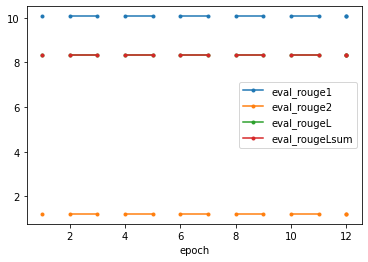

In [16]:
# Print the metrics
print_custom('Printing the metrics')
print(metrics)

df = pd.DataFrame(trainer.state.log_history)

# Creating a line graph for the metrics
print_custom('Creating a line graph for the metrics')
df.plot(x='epoch', y=['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum'], style='.-')



Creating the validation loss graph
----------------------------------------------------------------------------------------------------


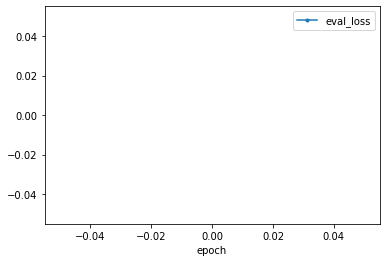

In [17]:
# Creating the validation loss graph 
print_custom('Creating the validation loss graph')
df.plot(x='epoch', y=['eval_loss'], style='.-')

In [18]:
# Save the model
drive_path_to_save_model = 'gdrive/My Drive/fyp/Models/' + MODEL_NAME + '_model'
model.save_pretrained(drive_path_to_save_model)

Configuration saved in gdrive/My Drive/fyp/Models/google/pegasus-x-base_model/config.json
Model weights saved in gdrive/My Drive/fyp/Models/google/pegasus-x-base_model/pytorch_model.bin


In [19]:
# Save the tokenizer
drive_path_to_save_tokenizer = 'gdrive/My Drive/fyp/Models/' + MODEL_NAME + '_tokenizer'
tokenizer.save_pretrained(drive_path_to_save_tokenizer)

tokenizer config file saved in gdrive/My Drive/fyp/Models/google/pegasus-x-base_tokenizer/tokenizer_config.json
Special tokens file saved in gdrive/My Drive/fyp/Models/google/pegasus-x-base_tokenizer/special_tokens_map.json


('gdrive/My Drive/fyp/Models/google/pegasus-x-base_tokenizer/tokenizer_config.json',
 'gdrive/My Drive/fyp/Models/google/pegasus-x-base_tokenizer/special_tokens_map.json',
 'gdrive/My Drive/fyp/Models/google/pegasus-x-base_tokenizer/spiece.model',
 'gdrive/My Drive/fyp/Models/google/pegasus-x-base_tokenizer/added_tokens.json',
 'gdrive/My Drive/fyp/Models/google/pegasus-x-base_tokenizer/tokenizer.json')